# import the libraries

In [15]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import r2_score,mean_squared_error

sns.set_style("darkgrid")
%matplotlib inline

# read the data

In [16]:
train=pd.read_csv("train.csv")

# EDA

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209673 entries, 0 to 209672
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_duration       209673 non-null  float64
 1   distance_traveled   209673 non-null  float64
 2   num_of_passengers   209673 non-null  float64
 3   fare                209673 non-null  float64
 4   tip                 209673 non-null  int64  
 5   miscellaneous_fees  209673 non-null  float64
 6   total_fare          209673 non-null  float64
 7   surge_applied       209673 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 12.8 MB


In [18]:
train.duplicated().sum()

4325

In [19]:
train.drop_duplicates(keep='first',ignore_index=True,inplace=True)

In [20]:
train.isna().sum()

trip_duration         0
distance_traveled     0
num_of_passengers     0
fare                  0
tip                   0
miscellaneous_fees    0
total_fare            0
surge_applied         0
dtype: int64

In [21]:
train.head().style.background_gradient()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748.000000,2.750000,1.000000,75.000000,24,6.300000,105.300000,0
1,1187.000000,3.430000,1.000000,105.000000,24,13.200000,142.200000,0
2,730.000000,3.120000,1.000000,71.250000,0,26.625000,97.875000,1
3,671.000000,5.630000,3.000000,90.000000,0,9.750000,99.750000,0
4,329.000000,2.090000,1.000000,45.000000,12,13.200000,70.200000,0


In [22]:
train.tail().style.background_gradient(cmap='PuBuGn')

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
205343,1617.000000,8.420000,1.000000,150.000000,47,5.800000,202.800000,0
205344,438.000000,1.290000,1.000000,48.750000,12,34.575000,95.325000,1
205345,571.000000,2.820000,1.000000,63.750000,0,6.000000,69.750000,0
205346,491.000000,2.160000,1.000000,56.250000,0,13.500000,69.750000,0
205347,3614.000000,33.720000,1.000000,337.500000,0,2.250000,339.750000,0


In [23]:
X=train.drop(['fare','tip','total_fare'],axis=1)
y=train['fare']

<AxesSubplot: >

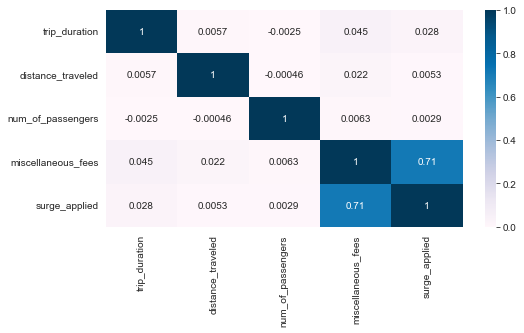

In [24]:
plt.figure(figsize=(8,4))
sns.heatmap(X.corr(),annot=True,cmap='PuBu')

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [26]:
vif=pd.DataFrame(index=X.columns)
vif['vif']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif=vif.sort_values(by='vif',ascending=False)

In [27]:
vif.style.background_gradient()

,vif
miscellaneous_fees,3.757033
surge_applied,2.782965
num_of_passengers,1.690004
trip_duration,1.053988
distance_traveled,1.002311


In [28]:
train.describe().style.background_gradient(cmap='crest')

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
count,205348.000000,205348.000000,205348.000000,205348.000000,205348.000000,205348.000000,205348.000000,205348.000000
mean,1189.102226,5.123167,1.298654,100.656568,13.247560,15.294384,129.198512,0.285803
std,4824.302160,126.528223,0.939258,86.142902,20.507879,12.621609,99.283531,0.451797
min,0.000000,0.020000,0.000000,0.000000,0.000000,-0.500000,0.000000,0.000000
25%,454.000000,1.980000,1.000000,52.500000,0.000000,6.000000,73.125000,0.000000
50%,716.000000,3.250000,1.000000,78.750000,9.000000,9.750000,103.500000,0.000000
75%,1110.000000,5.810000,1.000000,116.250000,20.000000,26.525000,153.450000,1.000000
max,86387.000000,57283.910000,9.000000,4466.250000,2500.000000,435.000000,4472.250000,1.000000


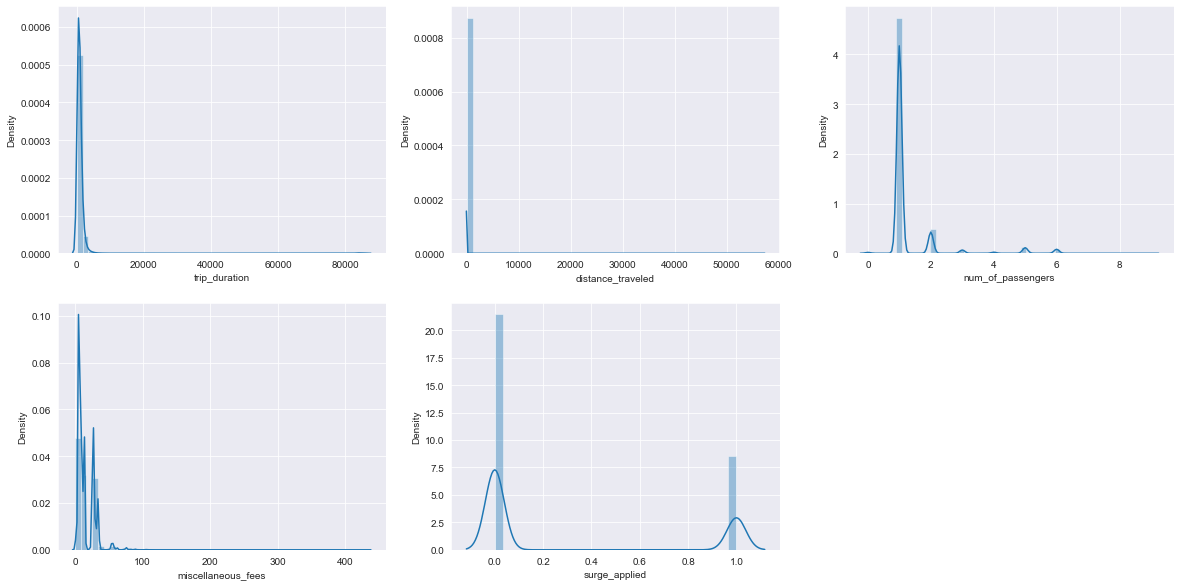

In [88]:
plt.figure(figsize=(20,10))
col=list(X.columns)
for i in range(len(col)):
    plt.subplot(2,3,(i+1))
    g=sns.distplot(train[col[i]])

In [29]:
def drop_outliers(df,col):
    print("initial shape of dataframe={}\n".format(df.shape[0]))
    q25,q75=np.percentile(df[col],25),np.percentile(df[col],75)
    iqr=q75-q25
    cut_off=iqr*1.5

    lower_lim=q25-cut_off
    uper_lim=q75+cut_off

    outliers=[x for x in df[col] if x>uper_lim or x<lower_lim]

    print("outliers identified for column {} are:{}\n".format(col,len(outliers)))
    
    df=df[~df[col].isin(outliers)]
    print("After removing outliers, shape of dataframe={}\n".format(df.shape[0]))
    
    return df

In [101]:
X.describe()

,trip_duration,distance_traveled,num_of_passengers,miscellaneous_fees,surge_applied
count,188281.000000,188281.000000,188281.000000,188281.000000,188281.000000
mean,734.914946,4.304388,1.297513,14.533671,0.272640
std,397.124225,132.073732,0.942867,11.249006,0.445319
min,0.000000,0.020000,0.000000,-0.500000,0.000000
25%,432.000000,1.900000,1.000000,6.000000,0.000000
50%,670.000000,3.030000,1.000000,9.750000,0.000000
75%,981.000000,4.970000,1.000000,26.425000,1.000000
max,1810.000000,57283.910000,9.000000,178.875000,1.000000


# model building

In [30]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=45)

In [31]:
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor

In [32]:
rf=RandomForestRegressor()
ar=AdaBoostRegressor()
gb=GradientBoostingRegressor()

In [43]:
def test_models(model):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    
    return r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred)

In [48]:
models=[rf,ar,gb]
model_names=['Random forest','Adaboost','Gradient boosting']
score=[]
error=[]

for model in models:
    sc,er=test_models(model)
    score.append(sc)
    error.append(er)

model_performance=pd.DataFrame({'model':model_names,'score':score,'error':error})


In [76]:
model_performance

,model,score,error
0,Random forest,0.750781,1985.613096
1,Adaboost,0.356462,5127.299118
2,Gradient boosting,0.750119,1990.892453


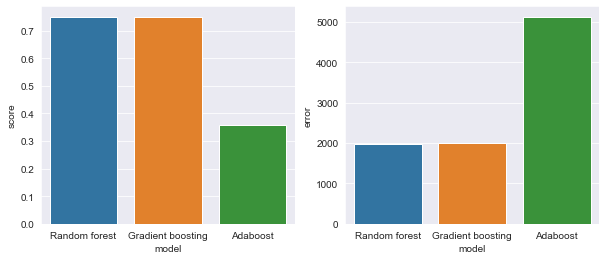

In [92]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
g=sns.barplot(model_performance,x='model',y='score',order=model_performance.sort_values(by='score',ascending=False).model)
plt.subplot(1,2,2)
g=sns.barplot(model_performance,x='model',y='error',order=model_performance.sort_values(by='error').model)

# Hyper parameter tuning

In [98]:
param_grid={"n_estimators":[100,120,150,200,300],
    "max_depth":[None,2,3,4,5,6],
    "min_samples_split":[2,3,4],
    "min_samples_leaf":[1,2,3]}
model=RandomizedSearchCV(rf,param_distributions=param_grid,cv=10)

In [100]:
model.fit(X_train,y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [None, 2, 3, 4, 5, 6],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [100, 120, 150, 200,
                                                         300]})

In [101]:
model.best_params_

{'n_estimators': 200,
 'min_samples_split': 4,
 'min_samples_leaf': 3,
 'max_depth': 6}

In [102]:
model.best_score_

0.7788836966020469

In [103]:
model=RandomForestRegressor(n_estimators=200,min_samples_split=4,min_samples_leaf=3,max_depth=6)

In [104]:
model.fit(X,y)

RandomForestRegressor(max_depth=6, min_samples_leaf=3, min_samples_split=4,
                      n_estimators=200)

In [ ]:
import pickle
pickle.dump(model,open("model.pkl",'wb'))

# model testing on test data

In [105]:
test

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,1076.0,4.18,1.0,0,0,13.500,0,0
1,429.0,1.48,4.0,0,0,13.500,0,0
2,856.0,4.15,1.0,0,24,6.000,0,0
3,622.0,3.22,1.0,0,15,5.625,0,0
4,507.0,3.98,1.0,0,0,2.250,0,0
...,...,...,...,...,...,...,...,...
89856,435.0,2.24,1.0,0,13,13.700,0,0
89857,519.0,2.61,1.0,0,7,13.850,0,0
89858,450.0,2.24,1.0,0,0,26.625,0,1
89859,919.0,4.12,1.0,0,25,30.200,0,1


In [108]:
fare=model.predict(test.drop(['fare','tip','total_fare'],axis=1))

In [109]:
fare

array([102.16066501,  50.77364747,  87.03322536, ...,  51.23573787,
        89.06038794,  60.04984486])

In [110]:
submission

,total_fare
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
89856,0.0
89857,0.0
89858,0.0
89859,0.0
